In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='ticks', context='notebook', font_scale=1.2)

## Section 1: Metadata

In [2]:
## Load survey data.
metadata = read_csv(os.path.join('data', 's1', 'metadata.csv'))
metadata = metadata.reset_index(drop=True)

#### 1.1 Comprehension Loops

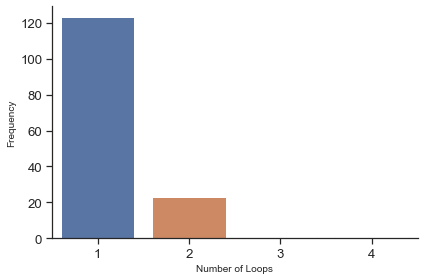

In [3]:
## Initialize rejection DataFrame.
reject = metadata[['subject', 'comprehension']].copy()

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot loops.
sns.countplot(x=reject['comprehension'], ax=ax)
ax.set(xlabel='Number of Loops', ylabel='Frequency')

sns.despine()
plt.tight_layout()

## Section 2: Surveys

In [4]:
## Load survey data.
surveys = read_csv(os.path.join('data', 's1', 'surveys.csv'))

#### 2.1 Infrequency Items

Following Huang et al. (2015) and Ophir et al. (2019), we included 3 infrequency items in our surveys (1 per survey). These are items with only  one  correct  or  highly  probable  answer. Previous research suggests that a zero-tolerance scoring of infrequency items is too severe ([Kim et al., 2018](http://dx.doi.org/10.3758/s13428-017-0964-9)), thus we will not reject based on a single improbable answer. 

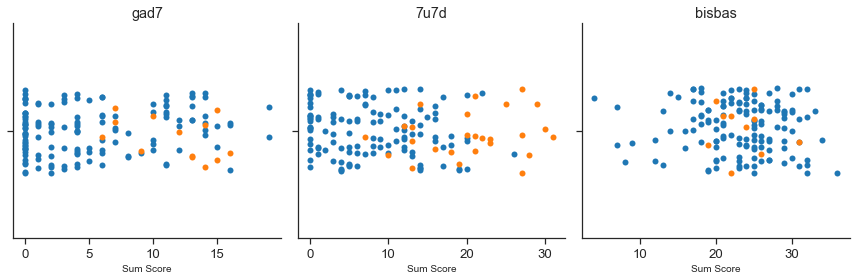

In [5]:
## Extract infrequency items.
infreq = surveys[['subject','gad7-q08','7u7d-q15','bisbas-q13']].copy()

## Threshold items. 
reject = reject.merge(infreq)
reject['gad7-q08'] = np.where(reject['gad7-q08'] > 0, 1, 0)
reject['7u7d-q15'] = np.where(reject['7u7d-q15'] > 0, 1, 0)
reject['bisbas-q13'] = np.where(reject['bisbas-q13'] > 1, 1, 0)
reject['infreq'] = reject[['gad7-q08','7u7d-q15','bisbas-q13']].sum(axis=1)

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

for ax, item in zip(axes, ['gad7-q08','7u7d-q15','bisbas-q13']):
    
    ## Compute sum scores.
    sum_scores = surveys.filter(regex=item[:-2]).drop(columns=item).sum(axis=1)
    
    ## Plot sum scores.
    sns.stripplot(x=sum_scores[reject[item]==0], color='#1f77b4', size=6, ax=ax)
    sns.stripplot(x=sum_scores[reject[item]==1], color='#ff7f0e', size=6, ax=ax)
    
    ## Add details.
    ax.set(xlabel='Sum Score', ylim=(-0.25,0.25), title=item[:-4])
    
sns.despine()
plt.tight_layout()

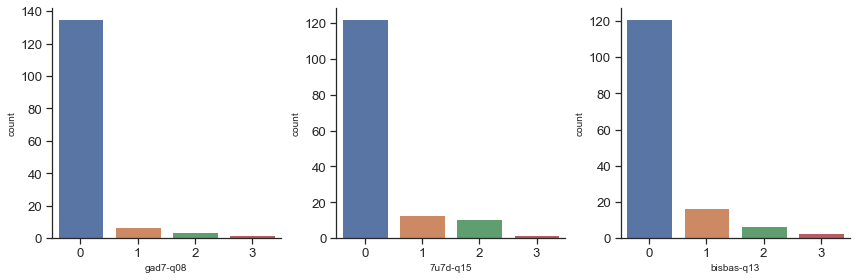

In [6]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

sns.countplot(x=surveys['gad7-q08'], ax=axes[0])
sns.countplot(x=surveys['7u7d-q15'], ax=axes[1])
sns.countplot(x=surveys['bisbas-q13'], ax=axes[2])

sns.despine()
plt.tight_layout()

## Section 3: Behavior

In [7]:
## Load behavioral data.
data = read_csv(os.path.join('data', 's1', 'pgng.csv'))

#### 3.1 Accuracy

For 240 total trials, a one-sided Binomial test is significantly different than chance at 133 trials, or approximately 55% accuracy.

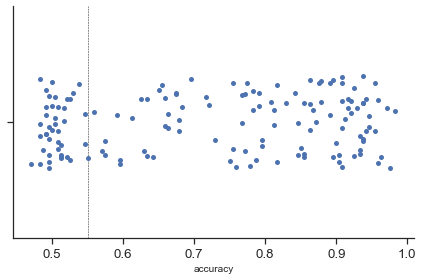

In [8]:
## Compute accuracy.
accuracy = data.groupby('subject').accuracy.mean().reset_index()
gw = data.query('robot=="gw"').groupby('subject').accuracy.mean().reset_index()

## Threshold.
reject = reject.merge(accuracy)
reject['accuracy'] = np.where(reject['accuracy'] < 0.55, 1, 0)
reject['accuracy'] = np.where(gw['accuracy'] < 0.55, 1, reject['accuracy'])

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot accuracy.
sns.stripplot(x=accuracy.accuracy, ax=ax)

## Add detail.
ax.axvline(0.55, lw=0.5, linestyle='--', color='k')
ax.set(ylim=(-0.25,0.25))

sns.despine()
plt.tight_layout()

#### 3.2 Response Times

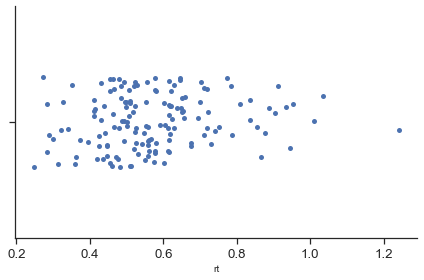

In [9]:
## Compute median response times.
rt = data.groupby('subject').rt.median().reset_index()

## Threshold.
reject = reject.merge(rt)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot accuracy.
sns.stripplot(x=rt.rt, ax=ax)

## Add detail.
ax.set(ylim=(-0.25,0.25))

sns.despine()
plt.tight_layout()

## Section 4: Apply Rejections

In [10]:
## Apply rejections.
reject['reject'] = np.logical_or(reject['accuracy'], reject['infreq'] > 1).astype(int)

## Save.
reject.to_csv(os.path.join('data', 's1', 'reject.csv'), index=False)

## Print info.
reject.set_index('subject').mean()

comprehension    1.189189
gad7-q08         0.087838
7u7d-q15         0.175676
bisbas-q13       0.067568
infreq           0.331081
accuracy         0.290541
rt               0.572277
reject           0.304054
dtype: float64